Import dependencies...

In [3]:
from rdkit.Chem.rdmolops import *
from rmgpy.molecule.fragment import Fragment
from rmgpy.tools.canteramodel import Cantera
from rmgpy.chemkin import *
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
rmgpy_loc = "/workspaces/RMG-Py/"
sys.path.append(rmgpy_loc)

Define a class called FragList for userfriendly random reattachment of fragments post-simulation...

In [4]:
class FragList():
    '''
    to instantiate a FragList:
    fl = Fraglist(frag_list) 
    where frag_list is a list of tuples of fragments and their amounts
    '''

    def __init__(self, frag_list):
        self.raw = frag_list

    def sort(self):
        '''
        sort a FragList into
            general_R_list - 2R fragments
            general_L_list - 2L fragments
            rr_ll_list - 2R or 2L fragments
            r_l_moles - 1R and 1L fragments
            multi_label_frag_3 - fragments with 3 cutting labels 
            multi_label_frag_4 - fragments with 4 cutting labels

            note: in our experience fragments with more than 4 cutting labels has never happened, but a warning will be printed if it does happen
        '''
        moles_remain = []
        one_R_dict = {}
        one_L_dict = {}
        general_R_list = []
        general_L_list = []
        rr_ll_list = []
        r_l_moles = []
        multi_label_frag_3 = []
        multi_label_frag_4 = []

        for i, item in enumerate(self.raw):
            frag, amt = item
            if amt > 1e-6 and '[' not in frag:
                if len(re.findall(r'R', frag)) == 0 and len(re.findall(r'L', frag)) == 0:
                    moles_remain.append((frag, amt))
                elif len(re.findall(r'R', frag)) == 1 and len(re.findall(r'L', frag)) == 0:
                    one_R_dict[frag] = amt
                elif len(re.findall(r'R', frag)) == 2 and len(re.findall(r'L', frag)) == 0:
                    general_R_list.append((frag, amt * 2))
                    rr_ll_list.append(frag)
                elif len(re.findall(r'R', frag)) == 0 and len(re.findall(r'L', frag)) == 1:
                    one_L_dict[frag] = amt
                elif len(re.findall(r'R', frag)) == 0 and len(re.findall(r'L', frag)) == 2:
                    general_L_list.append((frag, amt * 2))
                    rr_ll_list.append(frag)
                elif len(re.findall(r'R', frag)) == 1 and len(re.findall(r'L', frag)) == 1:
                    r_l_moles.append((frag, amt))
                else:
                    if len(re.findall(r'[LR]', frag)) == 3:
                        multi_label_frag_3.append(
                            (frag, amt))  # 2R1L, 1R2L, 3R, 3L
                    elif len(re.findall(r'[LR]', frag)) == 4:
                        multi_label_frag_4.append((frag, amt))
                    else:
                        print(
                            f"Warning! {len(re.findall(r'[LR]',frag))} cutting labels in {frag}")
        self.R1dict = one_R_dict
        self.L1dict = one_L_dict
        self.Rlist = general_R_list
        self.Llist = general_L_list
        self.RRLLlist = rr_ll_list
        self.RLlist = r_l_moles
        self.CL3 = multi_label_frag_3
        self.CL4 = multi_label_frag_4
        self.molesremain = moles_remain

    def random_pick_frag(target_dict):
        '''
        argument(s): target_dict - dictionary where key = species smiles (fragment or molecule), value = moles
        returns: tuple of randomly picked (fragment with 1 cutting label, moles)

        choice is weighted by mole fraction of each fragment
        '''
        import random
        import re
        frag_dict_list = [x for x in target_dict.items() if len(
            re.findall(r'[LR]', x[0])) == 1]
        sum_dict = sum([x[1] for x in frag_dict_list])
        frag_dict_prob = [x[1]/sum_dict for x in frag_dict_list]
        item = np.random.choice(frag_dict_list, 1, p=frag_dict_prob)

        return item

    def pair_frag(amount, target_dict):
        '''
        argument(s): amount - maximum amount of fragments in one pair
                    target_dict - dictionary of species smiles and moles
        returns: the target_dict with 1 randomly chosen 1-cutting label fragment fully paired with other randomly chosen 1-cutting label fragments
        '''
        additional_frag_list = []
        frag1 = FragList.random_pick_frag(target_dict)

        if target_dict[frag1] >= amount:
            target_dict[frag1] -= amount
            additional_frag_list.append((frag1, amount))

        else:
            remain = amount - target_dict[frag1]
            additional_frag_list.append((frag1, amount))
            target_dict[frag1] = 0

            while remain > 0:
                frag1 = FragList.random_pick_frag(target_dict)

                if target_dict[frag1] >= remain:
                    target_dict[frag1] -= remain
                    additional_frag_list.append((frag1, remain))
                    remain = 0

                else:
                    frag_amt = target_dict[frag1]
                    target_dict[frag1] = 0
                    additional_frag_list.append((frag1, frag_amt))
                    remain = remain - frag_amt
        return additional_frag_list

    def pair_CL4s(self):
        '''
        pairs all 4-cutting label fragments with other randomly picked 1-cutting label fragments, creating 3-cutting label fragments
        '''

        for species, amount in self.CL4:  # 4R, 3R1L, 2R2L, 1R3L, 4L

            if len(re.findall(r'R', species)) == 4 and len(re.findall(r'L', species)) == 0:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 4R
                    frag_new = merge_frag_to_frag(
                        frag1, frag2, 'R')  # L,R,R -> 3
                    self.CL3.append((frag_new, amt))

            elif len(re.findall(r'R', species)) == 0 and len(re.findall(r'L', species)) == 4:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 4L
                    frag_new = merge_frag_to_frag(
                        frag2, frag1, 'R')  # L,R,R -> 3L
                    self.CL3.append((frag_new, amt))

            elif len(re.findall(r'R', species)) == 2 and len(re.findall(r'L', species)) == 2:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 2R2L
                    frag_new = merge_frag_to_frag(
                        frag1, frag2, 'R')  # L,R,R -> 1R2L
                    self.CL3.append((frag_new, amt))

            elif len(re.findall(r'R', species)) == 3 and len(re.findall(r'L', species)) == 1:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 3R1L
                    frag_new = merge_frag_to_frag(
                        frag2, frag1, 'R')  # L,R,R -> 3R
                    self.CL3.append((frag_new, amt))

            elif len(re.findall(r'R', species)) == 1 and len(re.findall(r'L', species)) == 3:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 1R3L
                    frag_new = merge_frag_to_frag(
                        frag1, frag2, 'R')  # L,R,R -> 3L
                    self.CL3.append((frag_new, amt))

    def pair_CL3s(self):
        '''
        pairs all 3-cutting label fragments with other randomly picked 1-cutting label fragments, creating 2-cutting label fragments
        '''

        for species, amount in self.CL3:
            if len(re.findall(r'R', species)) == 2 and len(re.findall(r'L', species)) == 1:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 2R1L
                    frag_new = merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R
                    self.Rlist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            elif len(re.findall(r'R', species)) == 1 and len(re.findall(r'L', species)) == 2:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 1R2L
                    frag_new = merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R
                    self.Llist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            elif len(re.findall(r'R', species)) == 3 and len(re.findall(r'L', species)) == 0:
                paired_frag_list = FragList.pair_frag(amount, self.L1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1L
                    frag2 = species  # 3R
                    frag_new = merge_frag_to_frag(frag1, frag2, 'R')  # L,R,R
                    self.Rlist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

            # 3L
            elif len(re.findall(r'R', species)) == 0 and len(re.findall(r'L', species)) == 3:
                paired_frag_list = FragList.pair_frag(amount, self.R1dict)
                for frag_amt in paired_frag_list:
                    frag = frag_amt[0]
                    amt = frag_amt[1]
                    frag1 = frag  # 1R
                    frag2 = species  # 3L
                    frag_new = merge_frag_to_frag(frag2, frag1, 'R')  # L,R,R
                    self.Llist.append((frag_new, amt * 2))
                    self.RRLLlist.append(frag_new)

    def update_lists(self):
        '''
        adds the 1-cuttinglabel fragments remaining after pairing 4- and 3-cutting label fragments to their corresponding list
        '''
        for one_R_frag, amt in self.R1dict.items():
            self.Rlist.append((one_R_frag, amt))
        for one_L_frag, amt in self.L1dict.items():
            self.Llist.append((one_L_frag, amt))

    def grind(conc, size):
        """
        Split fragment concentrations into several repeating concentration units with specified size
        """
        grinded_conc = []
        for label, c in conc:
            times = int(c / size)
            grinded_conc.extend([(label, size)] * times)

            if c - size * times > 0:
                grinded_conc.append((label, c - size * times))

        return grinded_conc

    def match_sequences(seq1, seq2, diff_tol=1e-6):
        """
        Given two lists (each item is int or float):
        seq1 and seq2 with same sum, the method returns
        matched indices and values.
        Example:
        seq1 = [1, 3, 1]
        seq2 = [2, 1, 2]
        return: [[(0,0),1],
                        [(1,0),1],
                        [(1,1),1],
                        [(1,2),1],
                        [(2,2),1]]
        """
        # check if sums are close to same
        sum_diff = sum(seq2) - sum(seq1)
        assert (
            abs(sum_diff / 1.0 / sum(seq1)) <= diff_tol
        ), "seq1 has different sum (diff={0}) than seq2.".format(sum_diff)

        # force the sum to be same if the difference
        # is small enough
        if sum_diff >= 0:
            seq1[-1] = seq1[-1] + sum_diff
        else:
            seq2[-1] = seq2[-1] - sum_diff

        # make cumulative sequences
        cum_seq1 = [seq1[0]]
        for item1 in seq1[1:]:
            cum_seq1.append(cum_seq1[-1] + item1)

        cum_seq2 = [seq2[0]]
        for item2 in seq2[1:]:
            cum_seq2.append(cum_seq2[-1] + item2)

        # add index tags two both cumulative seqs
        pin1 = 0
        pin2 = 0
        matched_indices = []
        matched_cum_values = []
        while pin1 < len(cum_seq1) and pin2 < len(cum_seq2):
            matched_indices.append((pin1, pin2))

            if cum_seq1[pin1] > cum_seq2[pin2]:
                matched_cum_values.append(cum_seq2[pin2])
                pin2 += 1
            elif cum_seq1[pin1] < cum_seq2[pin2]:
                matched_cum_values.append(cum_seq1[pin1])
                pin1 += 1
            else:
                matched_cum_values.append(cum_seq2[pin2])
                pin1 += 1
                pin2 += 1

        # get matches
        matches = []
        for i in range(len(matched_indices)):
            matched_index_tup = matched_indices[i]
            matched_cum_value = matched_cum_values[i]
            if i == 0:
                previous_cum_value = 0
            else:
                previous_cum_value = matched_cum_values[i - 1]

            matches.append(
                [matched_index_tup, matched_cum_value - previous_cum_value])

        return matches

    def match_concentrations_with_same_sums(conc1, conc2, diff_tol=1e-6):
        """match_concentrations_with_same_sums
        Given two lists with each item to be a tuple
        (species label, concentration)
        conc1 and conc2 with same total concentrations,
        the method returns matched species labels and
        concentrations.
        Example:
        conc1 = [('a', 1),
                        ('b', 3),
                        ('c', 1)]
        conc2 = [('x', 2),
                        ('y', 1),
                        ('z', 2)]
        return: [(('a','x'),1),
                        (('b','x'),1),
                        (('b','y'),1),
                        (('b','z'),1),
                        (('c','z'),1)]
        """
        labels1 = [tup[0] for tup in conc1]
        labels2 = [tup[0] for tup in conc2]

        seq1 = [tup[1] for tup in conc1]
        seq2 = [tup[1] for tup in conc2]

        matches_seq = FragList.match_sequences(seq1, seq2, diff_tol)

        matches_conc = []
        for match_seq in matches_seq:
            matched_label_index1 = match_seq[0][0]
            matched_label_index2 = match_seq[0][1]
            matched_value = match_seq[1]

            matched_label1 = labels1[matched_label_index1]
            matched_label2 = labels2[matched_label_index2]
            match_conc = ((matched_label1, matched_label2), matched_value)
            matches_conc.append(match_conc)
        return matches_conc

    def match_concentrations_with_different_sums(conc1, conc2):
        """
        Given two lists with each item to be a tuple
        (species label, concentration)
        conc1 and conc2 with different total concentrations,
        the method returns matched species labels and
        concentrations.
        Example:
        conc1 = [('a', 1),
                        ('b', 3),
                        ('c', 1)]
        conc2 = [('x', 2),
                        ('y', 1),
                        ('z', 10)]
        return: [(('a','x', 'z', 'z'),1),
                        (('b','x', 'z', 'z'),1),
                        (('b','y', 'z', 'z'),1),
                        (('b','z', 'z'),1),
                        (('c','z', 'z'),1)]
        """
        labels1 = [tup[0] for tup in conc1]
        labels2 = [tup[0] for tup in conc2]

        seq1 = [tup[1] for tup in conc1]
        seq2 = [tup[1] for tup in conc2]

        matches_conc = []
        pin1 = 0
        pin2 = 0
        val1 = seq1[pin1]
        val2 = seq2[pin2]

        while True:
            if val1 > val2:
                match = ((labels1[pin1], labels2[pin2]), val2)
                matches_conc.append(match)
                val1 = val1 - val2
                pin2 += 1
                if pin2 == len(seq2):
                    break
                val2 = seq2[pin2]
            elif val1 < val2:
                match = ((labels1[pin1], labels2[pin2]), val1)
                matches_conc.append(match)
                val2 = val2 - val1
                pin1 += 1
                if pin1 == len(seq1):
                    break
                val1 = seq1[pin1]
            else:
                match = ((labels1[pin1], labels2[pin2]), val1)
                matches_conc.append(match)
                pin1 += 1
                pin2 += 1
                if pin1 == len(seq1):
                    break
                val1 = seq1[pin1]
                if pin2 == len(seq2):
                    break
                val2 = seq2[pin2]

        # if pin2 first reaches the end
        # append all the remaining seq1 to matches_conc
        if pin2 == len(seq2) and pin1 < len(seq1):
            remain_conc1 = [(labels1[pin1], val1)] + conc1[(pin1 + 1):]
            matches_conc.extend(remain_conc1)

        # if pin1 first reaches the end
        # let matches_conc match with remaining seq2
        elif pin1 == len(seq1) and pin2 < len(seq2):
            remain_conc2 = [(labels2[pin2], val2)] + conc2[(pin2 + 1):]
            matches_conc = FragList.match_concentrations_with_different_sums(
                matches_conc, remain_conc2
            )

        # if pin1 and pin2 reach the ends at same time
        # matches_conc is ready to return
        return matches_conc

    def shuffle(conc, seed=None):
        """
        Randomly shuffle a list of fragments
        """
        idx_arr = np.arange(len(conc))

        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(idx_arr)

        return [conc[idx] for idx in idx_arr]

    def flatten(combo):
        """
        Given a combo nested `tuple`, e.g.,
        ((('LY', 'XR'), ('LWL', 'RUR'))
        return a list of labels contained in
        the combo ['LY', 'XR', 'LWL', 'RUR']
        """
        return_list = []
        for i in combo:
            if isinstance(i, tuple):
                return_list.extend(FragList.flatten(i))
            else:
                return_list.append(i)
        return return_list

    def merge_frag_list(to_be_merged):
        import os
        # merges fragments in list from right to left
        species_list = []
        ethylene = []
        newlist = []
        warnings = []
        try:
            while len(to_be_merged) > 1:

                # second to last fragmentin list
                frag1 = to_be_merged[-2].smiles
                frag2 = to_be_merged[-1].smiles  # last fragment in list

                if 'R' in frag1 and 'L' in frag2:
                    newfrag = merge_frag_to_frag(frag1, frag2, 'L')

                elif 'L' in frag1 and 'R' in frag2:
                    newfrag = merge_frag_to_frag(frag1, frag2, 'R')

                # warn user if last two fragments in list cannot be merged (no R/L combo to be made)
                else:
                    print('Warning! Could not merge fragments {} and {}'.format(
                        frag1, frag2))

                    if 'L' in frag1 and 'L' in frag2:
                        newfrag = merge_frag_to_frag(
                            frag1.replace('L', 'R'), frag2, 'L')
                if len(to_be_merged) > 2:
                    cut = len(to_be_merged)-2
                    newfraglist = to_be_merged[:cut]

                    newfraglist.append(newfrag)
                elif len(to_be_merged) == 2:

                    newfraglist = [newfrag]

                to_be_merged = newfraglist

            to_be_merged = newfraglist
            # newlist.append(newfraglist) # if done merging list, write final structure to list of smiles structures

        except:

            newfraglist = to_be_merged

            # print('{}% of fragments fully merged...'.format(np.round(100*(i+1)/len(flattened_matches_random)),1))
        # print(newfraglist)
        return newfraglist

    def grind_endcaps(self, grindsize=1, repeats=1):
        '''
        splits each fragment concentration in to many subconcentrations of a maximum of grindsize
        '''
        print('grinding endcaps to {}'.format(grindsize))
        self.repeats = repeats
        if self.repeats == 1:
            self.grindsize = grindsize
            seed = np.random.randint(0, 100)
            grmoles = FragList.grind(self.Rlist, self.grindsize)
            glmoles = FragList.grind(self.Llist, self.grindsize)
            self.glmoles = FragList.shuffle(glmoles, seed)
            self.grmoles = FragList.shuffle(grmoles, seed+1)
        else:
            print('repeats > 1 not supported')

    def pair_endcaps(self):
        '''
        randomly pairs subconcentrations of endcaps and assigns the correct amount for each pair
        2L and 2R fragments will be paired with 2 1-cuttinglabel fragments
        the remaining fragment subconcentrations are middle pieces
        '''
        matches = FragList.match_concentrations_with_same_sums(self.glmoles,
                                                               self.grmoles,
                                                               diff_tol=1e-3)
        self.endcaps = []
        self.middles = []
        for match in matches:
            pair = match[0]
            value = match[1]
            if value > 0.0:
                lfrag, rfrag = pair
                if lfrag not in self.RRLLlist:
                    if rfrag not in self.RRLLlist:
                        self.endcaps.append((pair, value))
                    elif rfrag in self.RRLLlist:
                        self.endcaps.append(((lfrag, rfrag, lfrag), value/2))
                    else:
                        raise Error
                elif lfrag in self.RRLLlist:
                    if rfrag not in self.RRLLlist:
                        self.endcaps.append(((rfrag, lfrag, rfrag), value/2))
                    elif rfrag in self.RRLLlist:
                        self.middles.append((pair, value/2))
                    else:
                        raise Error
                else:
                    raise Error

    def grind_middles(self):
        '''
        grinds the middle 1L1R fragments into subconcentrations
        the same grindsize is used as for the endcaps
        '''
        print('grinding middle pieces to {}'.format(self.grindsize))
        if self.repeats == 1:
            grinded_r_l_moles = FragList.grind(self.RLlist, self.grindsize)
            seed = np.random.randint(0, 100)
            self.middles = self.middles + \
                FragList.shuffle(grinded_r_l_moles, seed)
        else:
            print('repeats > 1 not supported')

    def distribute_middles(self):
        '''
        loop through the middle pieces
        randomly pick an endcap pair to add to
        repeat until no more middle pieces 
        '''
        import random
        sys.setrecursionlimit(15000)
        r_l_frag_distri_amt = [0 for i in range(len(self.endcaps))]
        r_l_frag_distri_dict = [{} for i in range(len(self.endcaps))]
        for i, r_l_tup in enumerate(self.middles):
            r_l_frag = r_l_tup[0]
            r_l_frag_amount = r_l_tup[1]
            rand_idx = random.randrange(len(self.endcaps))
            threshold = 1e-15
            while self.endcaps[rand_idx][1] <= threshold:
                rand_idx = random.randrange(len(self.endcaps))
            r_l_frag_distri_amt[rand_idx] += r_l_frag_amount
            r_l_dict = r_l_frag_distri_dict[rand_idx]
            if r_l_frag in r_l_dict.keys():
                r_l_dict[r_l_frag] += r_l_frag_amount
            else:
                r_l_dict[r_l_frag] = r_l_frag_amount
        matches_random = []
        for i in range(len(self.endcaps)):
            pair = self.endcaps[i]
            if r_l_frag_distri_dict[i].keys():
                r_l_matched = []
                for r_l_frag, amt in r_l_frag_distri_dict[i].items():
                    r_l_matched.append((r_l_frag, amt))
                match_list = FragList.match_concentrations_with_different_sums([
                                                                               pair], r_l_matched)
                for tups in match_list:
                    matches_random.append(tups)
        #         break
            else:  # means no r_l_frag matches to this R-L pair
                matches_random.append(pair)
        flattened_matches_random = [
            (tuple(FragList.flatten(m[0])), m[1]) for m in matches_random]

        self.grouped = []

        for non_cut_mole, val in self.molesremain:
            self.grouped.append(((non_cut_mole, ), val))

        self.grouped.extend(flattened_matches_random)

    def get_mwd(self, bins=10, fname='mwd.png'):
        self.mwd_amts = [x[1] for x in self.grouped]
        self.mwd_mws = []
        for fraglist, amt in self.grouped:
            mw = sum([Fragment().from_smiles_like_string(
                frag).get_molecular_weight()*1000 for frag in fraglist])
            self.mwd_mws.append(mw)

        self.histdata = plt.hist(
            self.mwd_mws, bins=bins, weights=self.mwd_amts)
        plt.xlabel("Molecular Weight (g/mol)")
        plt.ylabel("Moles")


Read chem.inp and species_dictionary.txt...

In [6]:
working_dir = os.path.join('./')
chemkin_path = os.path.join(working_dir, 'data/chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'data/species_dictionary.txt')
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)
species_list, reaction_list = load_chemkin_file(
    chemkin_path, species_dict_path)
species_dict = {}
for i, spe in enumerate(species_list):
    species_dict[spe.to_chemkin()] = spe

Set up initial conditions...

In [7]:
RC10L = species_dict['RC10L(1)']
LC10 = species_dict['LC10(3)']
RC10 = species_dict['RC10(2)']
reactorTypeList = ['IdealGasConstPressureTemperatureReactor']
molFracList = [{RC10: 1,
                RC10L: 160,
                LC10: 1}]
Tlist = ([725.0], 'K')
Plist = ([1.0], 'bar')
# Vlist = ([1], 'm3')
reactionTimeList = ([1], 'h')

Run simulation...

In [8]:
job = Cantera(species_list=species_list,
              reaction_list=reaction_list, output_directory='temp_detailed')
job.load_model()
job.generate_conditions(reactorTypeList, reactionTimeList,
                        molFracList, Tlist, Plist)
all_data = job.simulate()

Get simulation results...

In [9]:
time, dataList, _, _ = all_data[0]
T_data = np.array(dataList[0].data)
P_data = np.array(dataList[1].data)
V_data = np.array(dataList[2].data)
total_moles = P_data/8.314/T_data
total_moles_t0 = total_moles[0]
total_moles_tf = total_moles[-1]
T = Tlist[0][0]
t = reactionTimeList[0][0]

Sort species into fragments and remaining species...

In [10]:
moles_dict = {}  # key: Chemkin name of fragments, value: moles of fragsments at t_final
for i, mf in enumerate(dataList[6:]):
    spe = species_dict[mf.label].smiles
    moles_dict[spe] = max(mf.data[-1]*total_moles_tf, 0)
frag_list = list(moles_dict.items())

Randomly reattach fragments...


If a "maximum recursion depth exceeded" is encountered, try lowering the grindsize by an order of magnitude

grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005
grinding endcaps to 0.0005
grinding middle pieces to 0.0005


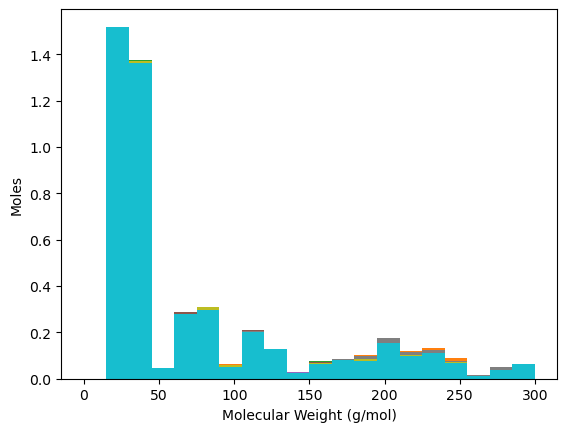

In [11]:
%matplotlib inline
hdl = []
hdl = []
for i in range(10):  # perform reattachment n times for repeatability analysis

    fl = FragList(frag_list)  # instantiate fraglist object

    fl.sort()  # sort the fragments by number and type of cutting labels

    fl.pair_CL4s()  # reattach 4-cutting label fragments to make 3-cutting label fragments

    fl.pair_CL3s()  # reattach 3-cutting label fragments to make 2-cutting label fragments

    fl.update_lists()  # add 1-cutting label fragments to either Rlist or Llist

    # grind the concentrations of fragments into smaller sub-concentrations
    fl.grind_endcaps(grindsize=0.0005)

    fl.pair_endcaps()  # pair together 1R and 1L fragments to make endcap pairs

    fl.grind_middles()  # grind the concentrations of middle LR fragments into smaller sub-concentrations of same size as above

    fl.distribute_middles()  # randomly select an endcap pair for each middle LR fragment

    # calculate and plot the molecular weight distribution of the resulting fragment groups
    fl.get_mwd(bins=range(0, 501, 15))

    hdl.append(fl.histdata)  # save histogram data for repeatability analysis




Examine repeatability of random reattachment...

If the repeatability is not satisfactory, try lowering the grindsize by an order of magnitude

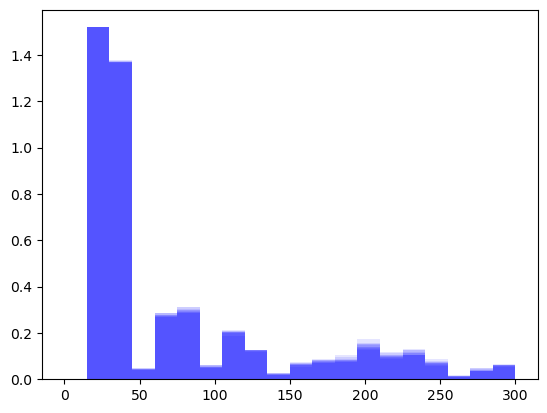

In [12]:
for hd in hdl:
    bins = hd[1]
    counts = hd[0]
    plt.hist(bins[:-1], bins, weights=counts, alpha=0.1, color='blue')

In [13]:
results_dictionary = {}
for fraglist, amt in fl.grouped:
    fraglist = [Fragment().from_smiles_like_string(x) for x in fraglist]
    if len(fraglist) == 1:
        new = fraglist[0].smiles
    elif len(fraglist) < 6:
        new = FragList.merge_frag_list(fraglist)[0].smiles
    else:
        new = 'miscillaneous large molecules'

    if new in results_dictionary.keys():
        results_dictionary[new] += amt
    else:
        results_dictionary[new] = amt
sorted_rd = sorted(results_dictionary.items(), key=lambda x: x[1])[::-1]
total = sum([x[1] for x in sorted_rd])
print('species'.ljust(80), 'mole percent'.rjust(30))
for x, y in sorted_rd:
    print(str(x).ljust(80, '.') +
          str(str(np.round(y/total*100, 2))+'%').rjust(30, '.'))

species                                                                                            mole percent
C.......................................................................................................24.35%
C=CC....................................................................................................20.14%
miscillaneous large molecules............................................................................9.27%
CCL......................................................................................................9.12%
C=CL.....................................................................................................8.86%
CC=CC(C)L................................................................................................5.96%
C=C(C)L..................................................................................................5.71%
C=CCC(C)L................................................................................................3.54%
